# Pylops - single-component acoustic wavefield separation

### Author: M.Ravasi

This notebook present a PyLops implementation of single-component acoustic wavefield separation.

The idea is to define the up-going field as our model and the total pressure field as our data and use an f-k propagator to predict the downgoing wavefield from the upgoing one. 

As we know that (apart from the direct arrival) the downgoing wavefield can be seen as the convolution of the upgoing wavefield with a ghost model:

$$p^+ - p_d = e^{-j k_z 2 z_{rec}} p^-$$

we can write:

$$\mathbf{W}_{p_d} \mathbf{p} = (\mathbf{I} + \Phi) \mathbf{p}^-$$ 

where $\Phi$ is the forward fk propagator and $\mathbf{W}$ is a mask that removes the direct arrival.


Conversely, we can try to predict the up-going field by convolving the downgoing field with the complex conjugate of the ghost model:

$$p^- + \delta =  e^{j k_z 2 z_{rec}} p^+$$

where we need to take into account the fact that the direct arrival will be focused at around -z_rec/v time into a band-limited $\delta$.

Again:

$$\mathbf{p} = \mathbf{W}_\delta (\mathbf{I} + \Phi_1) \mathbf{p}^+$$ 

where $\Phi_1$ is the backward fk propagator and $\mathbf{W}_\delta$ is a mask that removes the backpropagated direct arrival (which wraps arounds in the very end of part the time axis - consider padding the data with zeros to avoid overlap and cancellation of real events).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

## 2D

Let's import input data from file

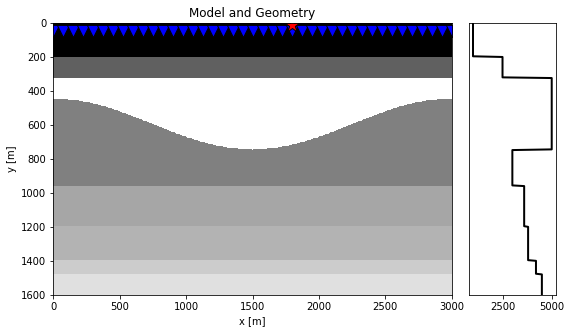

In [2]:
inputfile = '../data/updown/input.npz'
vel_sep = 2400.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']

# Model
rho = inputdata['rho']

# Axes
t = inputdata['t']
nt, dt = len(t), t[1]-t[0]
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Data
p = inputdata['p'].T

# Normalize
p /= p.max()

# Add noise
#p += np.random.normal(0, 1e4, p.shape)

# First arrival
direct = np.sqrt(np.sum((s[:,np.newaxis]-r)**2, axis=0))/vel_sep

fig = plt.figure(figsize=(9, 5))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=4)
ax2 = plt.subplot2grid((1, 5), (0, 4))
ax1.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
ax1.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
ax1.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
ax1.axis('tight')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_title('Model and Geometry')
ax1.set_xlim(x[0], x[-1]);
ax1.set_ylim(z[-1], z[0]);
ax2.plot(rho[:, len(x)//2], z, 'k', lw=2)
ax2.set_ylim(z[-1], z[0]);
ax2.set_yticks([], []);

## Pup estimation

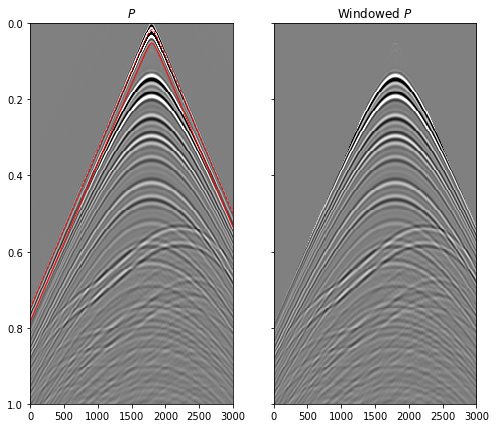

In [4]:
# Window
off = 0.035
direct_off = direct + off
win = np.zeros((nt, nr))
iwin = np.round(direct_off/dt).astype(np.int)
for i in range(nr):
    win[iwin[i]:, i] = 1

clip = 1e-1
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 7))
im=axs[0].imshow(p.T, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].plot(r[0], direct, '--r', lw=1)
axs[0].plot(r[0], direct_off, 'r', lw=1)
axs[0].set_title(r'$P$')
axs[0].axis('tight')
im=axs[1].imshow(win * p.T, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'Windowed $P$')
axs[1].axis('tight')
axs[1].set_ylim(1, 0);

In [5]:
# Phase shift operator
xpad = 5
dx = r[0, 1] - r[0, 0]
nf = nt
nkx = nr + 2*xpad
freq = np.fft.rfftfreq(nf, dt)
kx = np.fft.ifftshift(np.fft.fftfreq(nkx, dx))
#[F, Kx] = np.meshgrid(freq, kx, indexing='ij')

taper = taper2d(nt, nr, 11)
zprop = 2*r[1, 0] + 2*dz

Padop = Pad((nt, nr), ((0,0), (xpad, xpad)))
Pop = - Padop.H * PhaseShift(vel_sep, zprop, nt, freq, kx) * Padop * Diagonal(taper.T.ravel(), dtype='complex128')
dottest(Pop, nt*nr, nt*nr, verb=True)

# Decomposition with up-going model
Dupop = (Identity(nt*nr) + Pop)
dottest(Dupop, nt*nr, nt*nr, verb=True);

Dot test passed, v^T(Opu)=67.064443 - u^T(Op^Tv)=67.064443
Dot test passed, v^T(Opu)=435.388903 - u^T(Op^Tv)=435.388903


In [6]:
pup_inv, istop, itn, r1norm, r2norm = \
    lsqr(Dupop, (win * p.T).flatten(), damp=1e-10, 
         iter_lim=60, show=2)[0:5]
pup_inv = np.real(pup_inv)
pup_inv = pup_inv.reshape(nt, nr)
pdown_inv = p.T - pup_inv

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   217281 rows  and   217281 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       60
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.968e+00  6.968e+00    1.0e+00  2.4e-01
     1  0.00000e+00   2.436e+00  2.436e+00    3.5e-01  7.4e-01   1.8e+00  1.0e+00
     2  3.63634e-05   1.192e+00  1.192e+00    1.7e-01  3.9e-01   2.4e+00  2.1e+00
     3  7.51306e-05   8.279e-01  8.279e-01    1.2e-01  2.9e-01   2.7e+00  3.3e+00
     4  8.20661e-05   6.365e-01  6.365e-01    9.1e-02  2.2e-01   3.1e+00  4.8e+00
     5  7.01196e-05   5.119e-01  5.119e-01    7.3e-02  1.8e-01   3.4e+00  6.5e+00
     6  9.31559e-06   4.277e-01  4.277e-01    6.1e-02  1.6e-01   3.7e+00  8.3e+00
     7 -1.30792e-04   3.682e-01  3.682e-01    5.3e-02  1.3e-01   4.0e+00  1.0e+01
     8 -3.09927e-04   3.245e

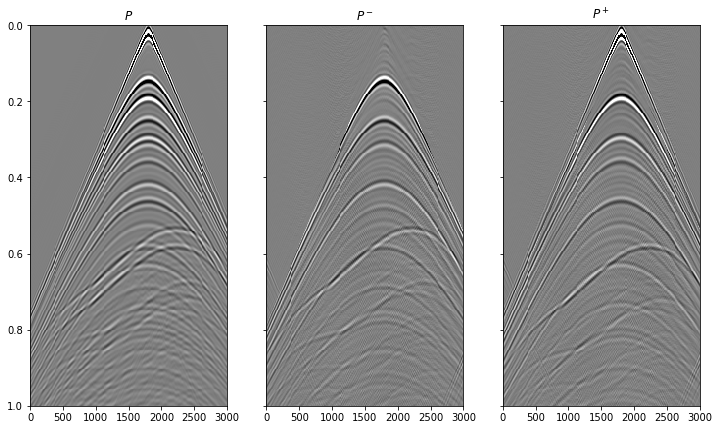

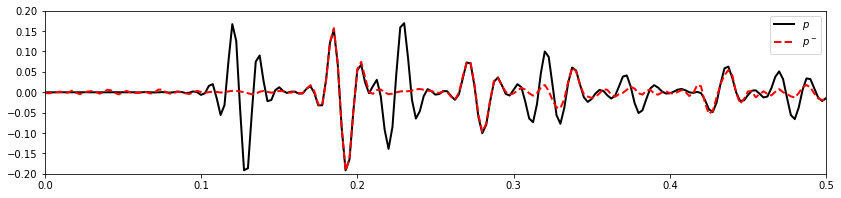

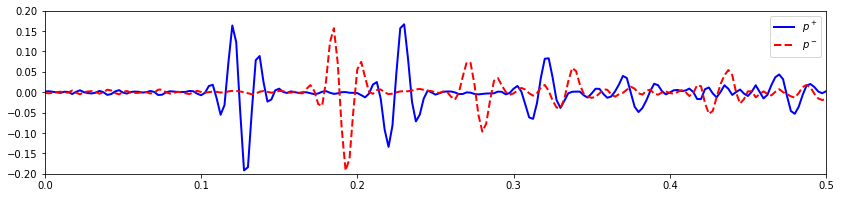

In [7]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 7))
axs[0].imshow(p.T, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$P$')
axs[0].axis('tight')
axs[1].imshow(pup_inv, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$P^-$')
axs[1].axis('tight')
axs[2].imshow(pdown_inv, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$P^+$')
axs[2].axis('tight');
axs[2].set_ylim(1, 0);

plt.figure(figsize=(14, 3))
plt.plot(t, p[nr//2], 'k', lw=2, label=r'$p$')
plt.plot(t, pup_inv[:, nr//2], '--r', lw=2, label=r'$p^-$')
plt.xlim(0, t[200])
plt.ylim(-0.2, 0.2)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pdown_inv[:, nr//2], 'b', lw=2, label=r'$p^+$')
plt.plot(t, pup_inv[:, nr//2], 'r', lw=2, label=r'$p^-$')
plt.xlim(0,t[200])
plt.ylim(-0.2, 0.2)
plt.legend();

## Pdown estimation

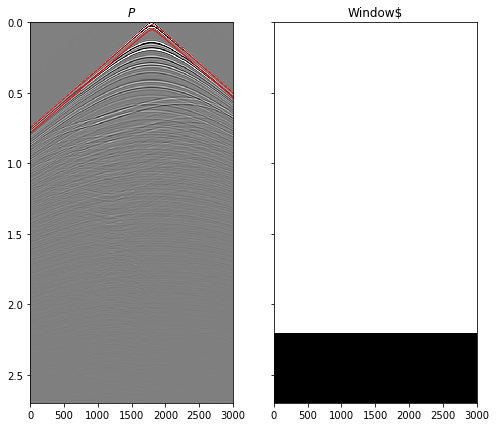

In [8]:
# Window for model
winm = np.zeros((nt, nr))
winm[:nt - 200] = 1

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 7))
im=axs[0].imshow(p.T, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].plot(r[0], direct, '--r', lw=1)
axs[0].plot(r[0], direct_off, 'r', lw=1)
axs[0].set_title(r'$P$')
axs[0].axis('tight')
im=axs[1].imshow(winm, cmap='gray',
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'Window$')
axs[1].axis('tight');

In [9]:
# Phase shift operator
xpad = 5
dx = r[0, 1] - r[0, 0]
nf = nt
nkx = nr + 2*xpad
freq = np.fft.rfftfreq(nf, dt)
kx = np.fft.ifftshift(np.fft.fftfreq(nkx, dx))
#[F, Kx] = np.meshgrid(freq, kx, indexing='ij')

taper = taper2d(nt, nr, 11)
zprop = 2*r[1, 0] + 2*dz

Padop = Pad((nt,nr), ((0,0), (xpad, xpad)))
P1op = - Padop.H * PhaseShift(vel_sep, -zprop, nt, freq, kx) * Padop * Diagonal(taper.T.ravel(), dtype='complex128')
dottest(Pop, nt*nr, nt*nr, verb=True)

# Decomposition with up-going model
Ddownop = Diagonal(winm.ravel()) * (Identity(nt*nr) + P1op)
dottest(Ddownop, nt*nr, nt*nr, verb=True);

Dot test passed, v^T(Opu)=464.755255 - u^T(Op^Tv)=464.755255
Dot test passed, v^T(Opu)=41.721044 - u^T(Op^Tv)=41.721044


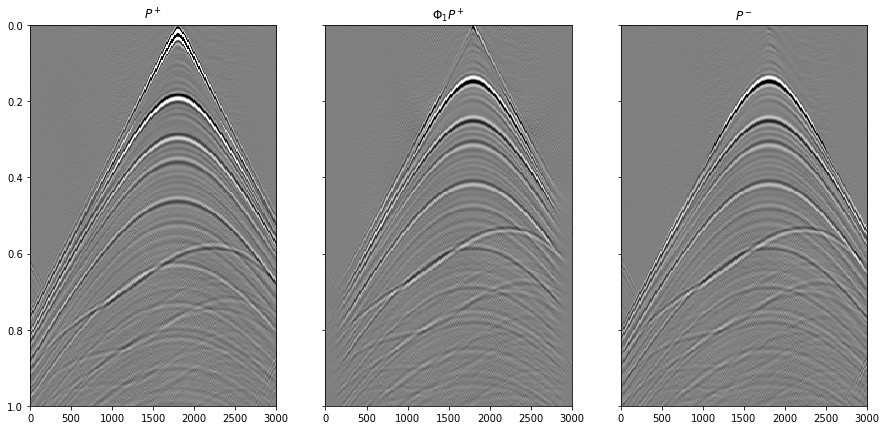

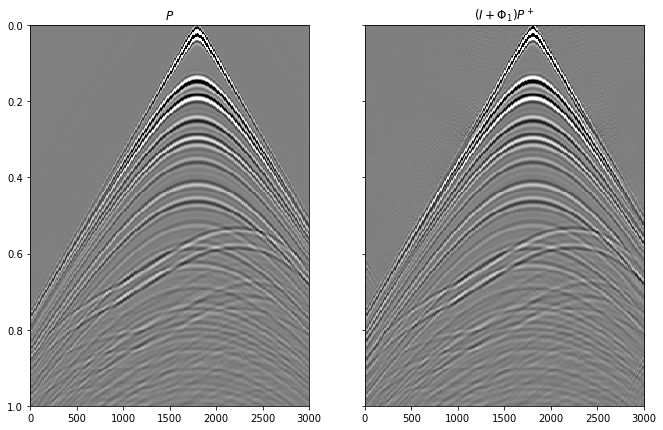

In [10]:
pup_mod = P1op * pdown_inv.ravel()
pup_mod = pup_mod.reshape(nt, nr)

p_mod = Ddownop * pdown_inv.ravel()
p_mod = p_mod.reshape(nt, nr)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 7))
axs[0].imshow(pdown_inv, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$P^+$')
axs[0].axis('tight')
axs[0].axis('tight')
axs[1].imshow(winm * pup_mod, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$\Phi_1 P^+$')
axs[1].axis('tight')
axs[1].set_ylim(1, 0);
axs[2].imshow(pup_inv, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$P^-$')
axs[2].axis('tight')
axs[2].set_ylim(1, 0);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(11, 7))
im=axs[0].imshow(p.T, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$P$')
axs[0].axis('tight')
im=axs[1].imshow(p_mod, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$(I + \Phi_1) P^+$')
axs[1].axis('tight')
axs[1].set_ylim(1, 0);

In [11]:
pdown_inv, istop, itn, r1norm, r2norm = \
    lsqr(Ddownop, p.T.flatten(), damp=1e-10, 
         iter_lim=60, show=2)[0:5]
pdown_inv = np.real(pdown_inv)
pdown_inv = pdown_inv.reshape(nt, nr)
pup_inv = p.T - pdown_inv

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   217281 rows  and   217281 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       60
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.123e+01  1.123e+01    1.0e+00  1.3e-01
     1  0.00000e+00   4.844e+00  4.844e+00    4.3e-01  7.3e-01   1.7e+00  1.0e+00
     2  1.46687e-05   2.579e+00  2.579e+00    2.3e-01  4.0e-01   2.3e+00  2.2e+00
     3 -5.96503e-05   1.778e+00  1.778e+00    1.6e-01  3.0e-01   2.7e+00  3.4e+00
     4 -2.96143e-04   1.345e+00  1.345e+00    1.2e-01  2.3e-01   3.0e+00  4.9e+00
     5 -4.81811e-04   1.087e+00  1.087e+00    9.7e-02  1.8e-01   3.3e+00  6.5e+00
     6 -3.85158e-04   9.097e-01  9.097e-01    8.1e-02  1.6e-01   3.6e+00  8.3e+00
     7 -8.30335e-06   7.839e-01  7.839e-01    7.0e-02  1.4e-01   3.9e+00  1.0e+01
     8  5.05199e-04   6.841e

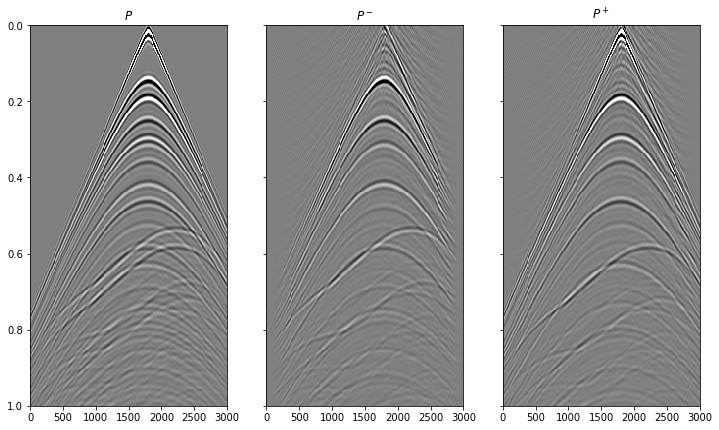

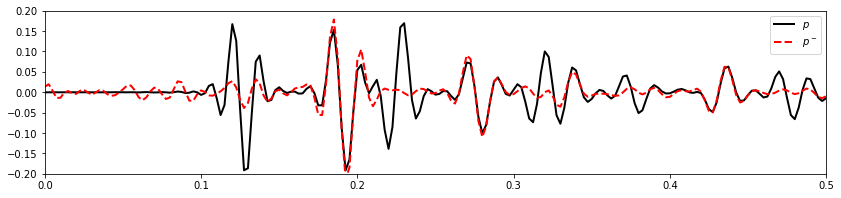

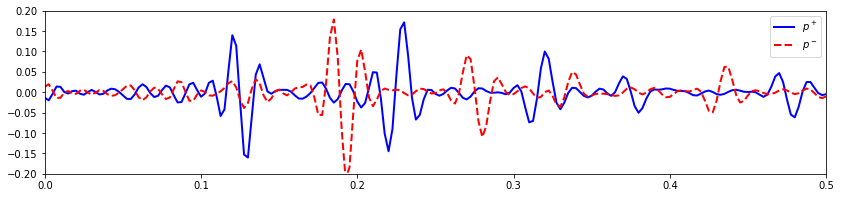

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 7))
axs[0].imshow(p.T, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$P$')
axs[0].axis('tight')
axs[1].imshow(pup_inv, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$P^-$')
axs[1].axis('tight')
axs[2].imshow(pdown_inv, cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$P^+$')
axs[2].axis('tight');
axs[2].set_ylim(1, 0);

plt.figure(figsize=(14, 3))
plt.plot(t, p[nr//2], 'k', lw=2, label=r'$p$')
plt.plot(t, pup_inv[:, nr//2], '--r', lw=2, label=r'$p^-$')
plt.xlim(0, t[200])
plt.ylim(-0.2, 0.2)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pdown_inv[:, nr//2], 'b', lw=2, label=r'$p^+$')
plt.plot(t, pup_inv[:, nr//2], 'r', lw=2, label=r'$p^-$')
plt.xlim(0,t[200])
plt.ylim(-0.2, 0.2)
plt.legend();

## 3D

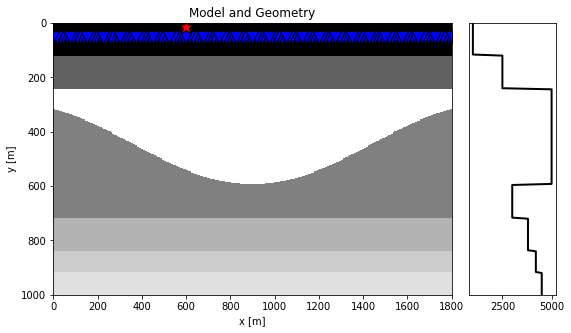

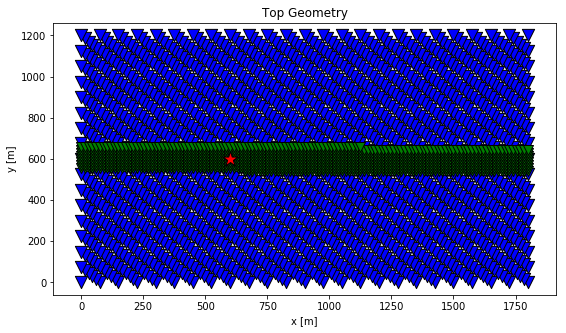

In [3]:
inputfile = '../data/updown/input3D.npz'
vel_sep = 2400.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

inputdata = np.load(inputfile)

# Receivers
r = inputdata['recs'].T
nr = r.shape[1]
nry, nrx = 121, 81
dr = r[0, 1]-r[0, 0]
dry = np.diff(r.reshape(3, nrx, nry)[0, 0])[0], 
drx = np.diff(r.reshape(3, nrx, nry)[1, :, 0])[0]

# Sources
s = inputdata['srcs'][inputdata['isrc']].T
s[2] = 15 # resave data

# Model
rho = inputdata['rho']

# Axes
t = inputdata['t']
nt, dt = len(t), t[1]-t[0]
y, x, z = inputdata['y'], inputdata['x'], inputdata['z']
ny, nx = len(y), len(x)
dy, dx, dz = y[1] - y[0], x[1] - x[0], z[1] - z[0]

# Data
p0 = inputdata['p0'].reshape(nt, nrx, nry)
p = inputdata['p'].reshape(nt, nrx, nry)

# Reduce time
nt = 550
p0 = p0[:nt]
p = p[:nt]
t = t[:nt]

# Normalize
p0 /= p.max()
p /= p.max()

# Add noise
#p += np.random.normal(0, 1e4, p.shape)

# First arrival
#direct = np.sqrt(np.sum((s[:,np.newaxis]-r)**2, axis=0))/vel_sep

# First reflection
zseabed = 120
rrefl = r.copy()
rrefl[2] = 2 * zseabed - r[2]
direct = np.sqrt(np.sum((s[:,np.newaxis]-rrefl)**2, axis=0))/vel_sep

fig = plt.figure(figsize=(9, 5))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=4)
ax2 = plt.subplot2grid((1, 5), (0, 4))
ax1.imshow(rho[ny//2].T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
ax1.scatter(r[0, ::5],  r[2, ::5], marker='v', s=150, c='b', edgecolors='k')
#ax1.scatter(rrefl[0, ::5],  rrefl[2, ::5], marker='v', s=150, c='b', edgecolors='k')
ax1.scatter(s[0], s[2], marker='*', s=250, c='r', edgecolors='k')
ax1.axis('tight')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_title('Model and Geometry')
ax1.set_xlim(x[0], x[-1]);
ax1.set_ylim(z[-1], z[0]);
ax2.plot(rho[ny//2, nx//2], z, 'k', lw=2)
ax2.set_ylim(z[-1], z[0]);
ax2.set_yticks([], [])

plt.figure(figsize=(9,5))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(r[0, nr//2 - 500: nr//2 + 500],  
            r[1, nr//2 - 500: nr//2 + 500], marker='v', s=100, c='g', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Top Geometry');

### Pup estimation

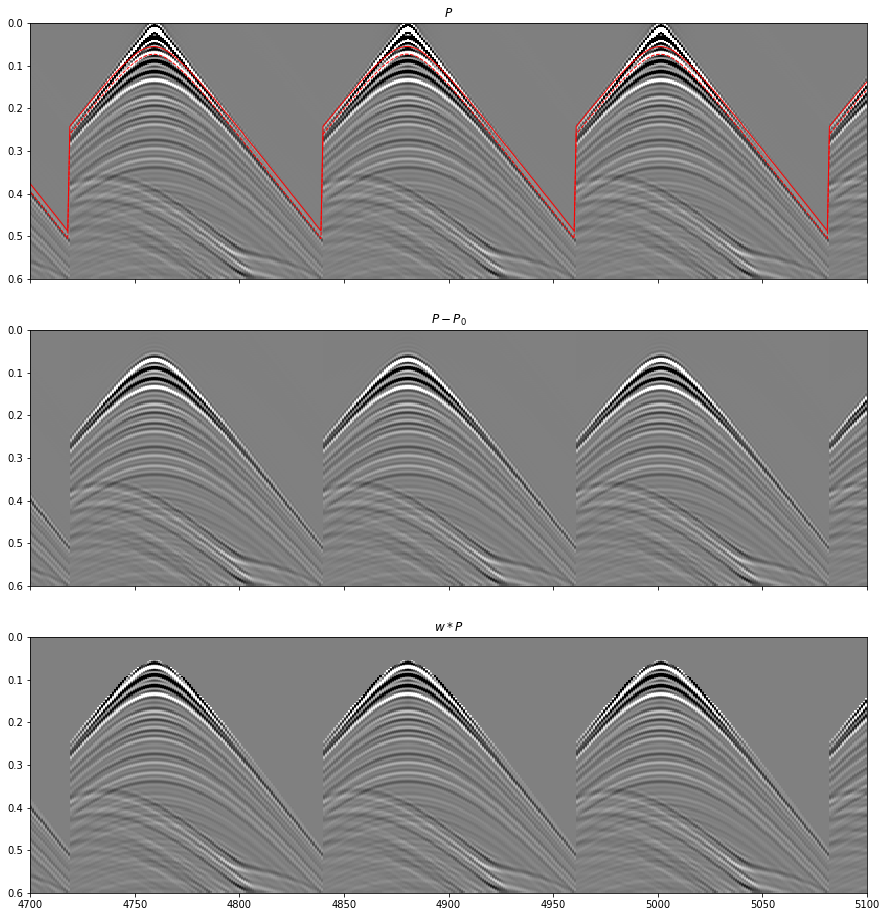

In [15]:
# Window
#off = 0.03 # first arrival
off = -0.018 # first reflection
direct_off = direct + off
win = np.zeros((nt, nrx * nry))
iwin = np.round(direct_off/dt).astype(np.int)
for i in range(nr):
    win[iwin[i]:, i] = 1
win = win.reshape(nt, nrx, nry)
#win = filtfilt(np.ones(5)/5, 1, win, axis=0)

clip = 3e-2
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(15, 16))
im=axs[0].imshow(p.reshape(nt, nrx*nry), cmap='gray', 
             vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
             extent = (0, nr, t[-1], t[0]))
axs[0].plot(np.arange(nr), direct, '--r', lw=1)
axs[0].plot(np.arange(nr), direct_off, 'r', lw=1)
axs[0].set_title(r'$P$')
axs[0].axis('tight')
axs[0].set_ylim(0.6, 0);
im=axs[1].imshow((p - p0).reshape(nt, nrx*nry), cmap='gray', 
             vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
             extent = (0, nr, t[-1], t[0]))
axs[1].set_title(r'$P - P_0$')
axs[1].axis('tight')
axs[1].set_xlim(nr//2 - 200, nr//2 + 200);
axs[1].set_ylim(0.6, 0);
im=axs[2].imshow((p * win).reshape(nt, nrx*nry), cmap='gray', 
             vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
             extent = (0, nr, t[-1], t[0]))
#axs[2].plot(np.arange(nr), direct_off, 'r', lw=1)
axs[2].set_title(r'$w * P$')
axs[2].axis('tight')
axs[2].set_xlim(nr//2 - 200, nr//2 + 200);
axs[2].set_ylim(0.6, 0);

In [16]:
# Phase shift operator
ypad, xpad = 21, 21
dx = r[0, 1] - r[0, 0]
dy = r[1, nry] - r[1, 0]
nf = nt
nkx = nrx + 2*xpad
nky = nry + 2*ypad
freq = np.fft.rfftfreq(nf, dt)
kx = np.fft.ifftshift(np.fft.fftfreq(nkx, dx))
ky = np.fft.ifftshift(np.fft.fftfreq(nky, dy))
#[F, Kx, Ky] = np.meshgrid(freq, kx, ky, indexing='ij')

tapert = np.ones(nt)
tapert[-40:] = 0
tapert = filtfilt(np.ones(21)/21, 1, tapert)
taper = taper3d(nt, (nrx, nry), (21, 21)).transpose(2, 0, 1) * tapert[:, np.newaxis, np.newaxis]
zprop = 2*r[2, 0] + 2*dz

Padop = Pad((nt, nrx, nry), ((0,0), (xpad, xpad), (ypad, ypad)))
Pop = - Padop.H * PhaseShift(vel_sep, zprop, nt, freq, kx, ky) * Padop * Diagonal(taper.ravel(), dtype='complex128')
dottest(Pop, nt*nr, nt*nr, verb=True)

# Decomposition with up-going model
Dupop = (Identity(nt*nr) + Pop)
dottest(Dupop, nt*nr, nt*nr, verb=True);

Dot test passed, v^T(Opu)=-220.843967 - u^T(Op^Tv)=-220.843967
Dot test passed, v^T(Opu)=-1475.225189 - u^T(Op^Tv)=-1475.225189


In [17]:
# Remove modelled direct wave
p_prop = Pop * (p - p0).flatten()
p_prop = np.real(p_prop)

pup_adj = Dupop.H * (p - p0).flatten()
pup_adj = np.real(pup_adj)

pup_inv, istop, itn, r1norm, r2norm = \
    lsqr(Dupop, (p - p0).flatten(), damp=1e-10, 
         iter_lim=30, show=2)[0:5]
pup_inv = np.real(pup_inv)
res = (p - p0).flatten() - Dupop * pup_inv

# Apply windowing
#pup_adj = Dupop.H * (win * p).flatten()
#pup_inv, istop, itn, r1norm, r2norm = \
#    lsqr(Dupop, (win * p).flatten(), damp=1e-10, 
#         iter_lim=30, show=2)[0:5]
#pup_inv = np.real(pup_inv)
#res = (win * p).flatten() - Dupop * pup_inv

p_prop = p_prop.reshape(nt, nrx, nry)
pup_adj = pup_adj.reshape(nt, nrx, nry)
pup_inv = pup_inv.reshape(nt, nrx, nry)
res = res.reshape(nt, nrx, nry)
pdown_inv = p - pup_inv

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 5.39055e+06 rows  and 5.39055e+06 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.316e+00  7.316e+00    1.0e+00  2.2e-01
     1  1.10980e-18   2.822e+00  2.822e+00    3.9e-01  6.1e-01   1.8e+00  1.0e+00
     2  8.80809e-06   1.700e+00  1.700e+00    2.3e-01  4.2e-01   2.2e+00  2.2e+00
     3  2.55161e-05   1.209e+00  1.209e+00    1.7e-01  2.6e-01   2.7e+00  3.5e+00
     4  4.05630e-05   9.732e-01  9.732e-01    1.3e-01  2.1e-01   3.0e+00  4.9e+00
     5  4.94294e-05   7.908e-01  7.908e-01    1.1e-01  1.9e-01   3.4e+00  6.7e+00
     6  4.94448e-05   6.434e-01  6.434e-01    8.8e-02  1.7e-01   3.6e+00  8.8e+00
     7  4.46030e-05   5.342e-01  5.342e-01    7.3e-02  1.5e-01   3.9e+00  1.1e+01
     8  4.01907e-05   

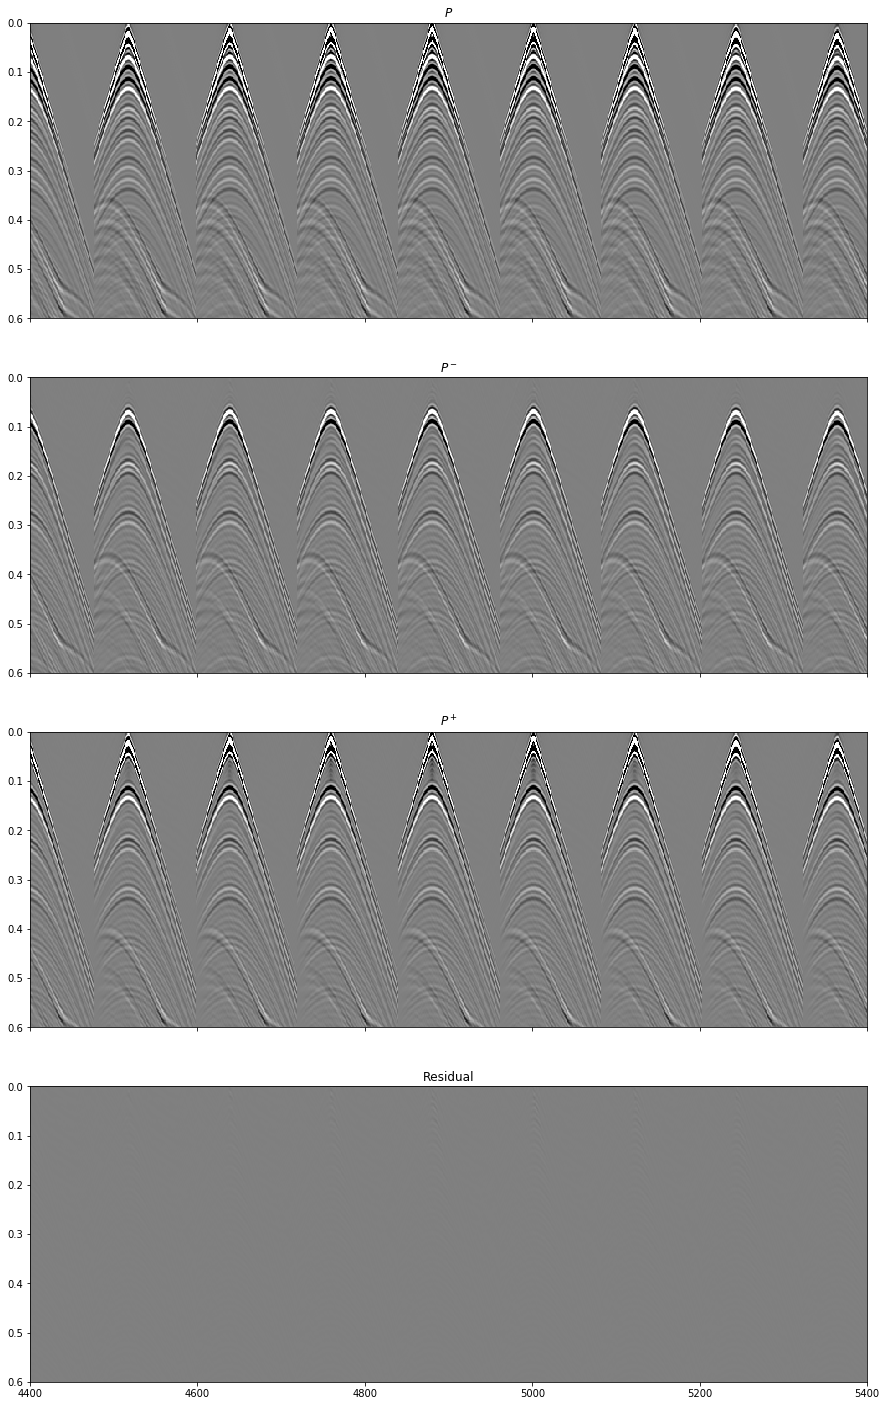

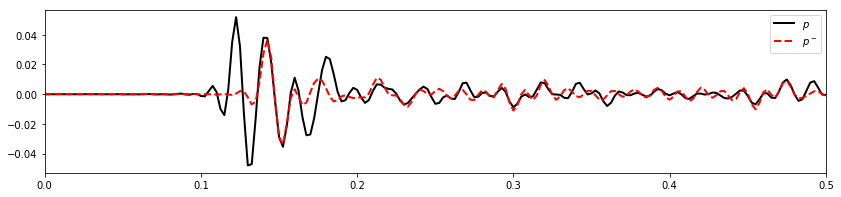

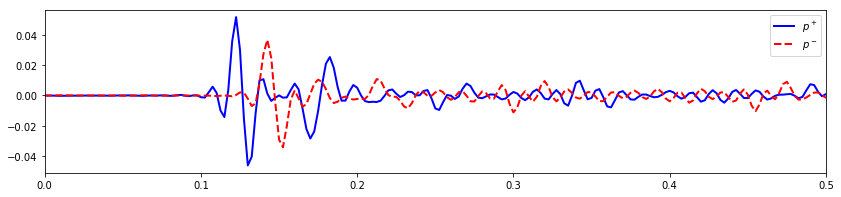

In [18]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 25))
axs[0].imshow(p.reshape(nt, nrx*nry), cmap='gray', 
              vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (0, nr, t[-1], t[0]))
axs[0].set_title(r'$P$')
axs[0].axis('tight')
axs[0].set_ylim(0.6, 0)
axs[1].imshow(pup_inv.reshape(nt, nrx*nry), cmap='gray', 
              vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (0, nr, t[-1], t[0]))
axs[1].set_title(r'$P^-$')
axs[1].axis('tight')
axs[1].set_ylim(0.6, 0)
axs[2].imshow(pdown_inv.reshape(nt, nrx*nry), cmap='gray', 
              vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (0, nr, t[-1], t[0]))
axs[2].set_title(r'$P^+$')
axs[2].axis('tight')
axs[2].set_ylim(0.6, 0)
axs[3].imshow(res.reshape(nt, nrx*nry), cmap='gray', 
              vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (0, nr, t[-1], t[0]))
axs[3].set_title('Residual')
axs[3].axis('tight')
axs[3].set_ylim(0.6, 0)
axs[3].set_xlim(nr//2 - 500, nr//2 + 500)

plt.figure(figsize=(14, 3))
plt.plot(t, p[:, nrx//2, nry//2], 'k', lw=2, label=r'$p$')
plt.plot(t, pup_inv[:, nrx//2, nry//2], '--r', lw=2, label=r'$p^-$')
plt.xlim(0, t[200])
#plt.ylim(-0.2, 0.2)
plt.legend()

plt.figure(figsize=(14, 3))
plt.plot(t, pdown_inv[:, nrx//2, nry//2], 'b', lw=2, label=r'$p^+$')
plt.plot(t, pup_inv[:, nrx//2, nry//2], '--r', lw=2, label=r'$p^-$')
plt.xlim(0, t[200])
#plt.ylim(-0.2, 0.2)
plt.legend();

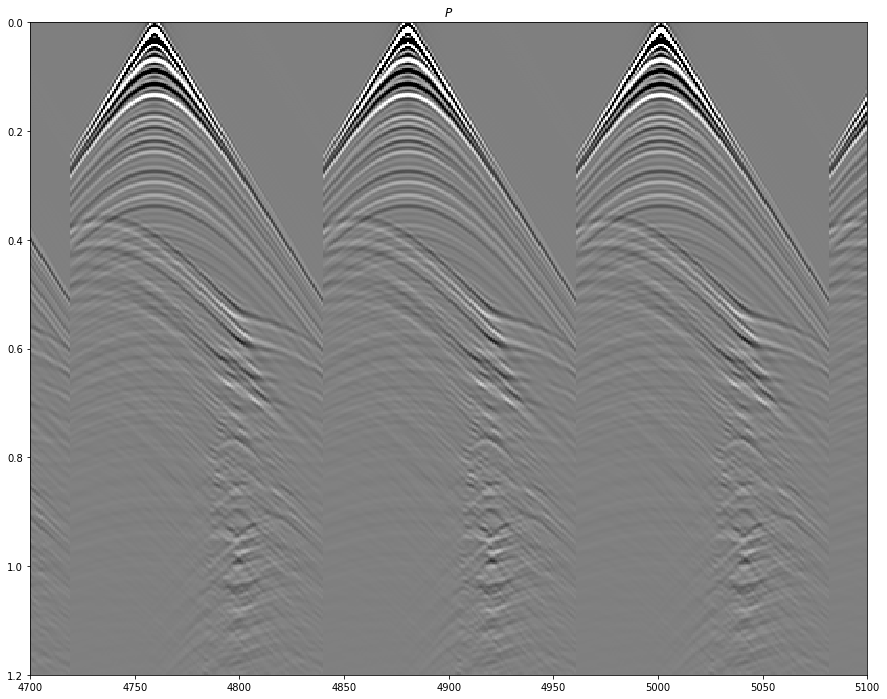

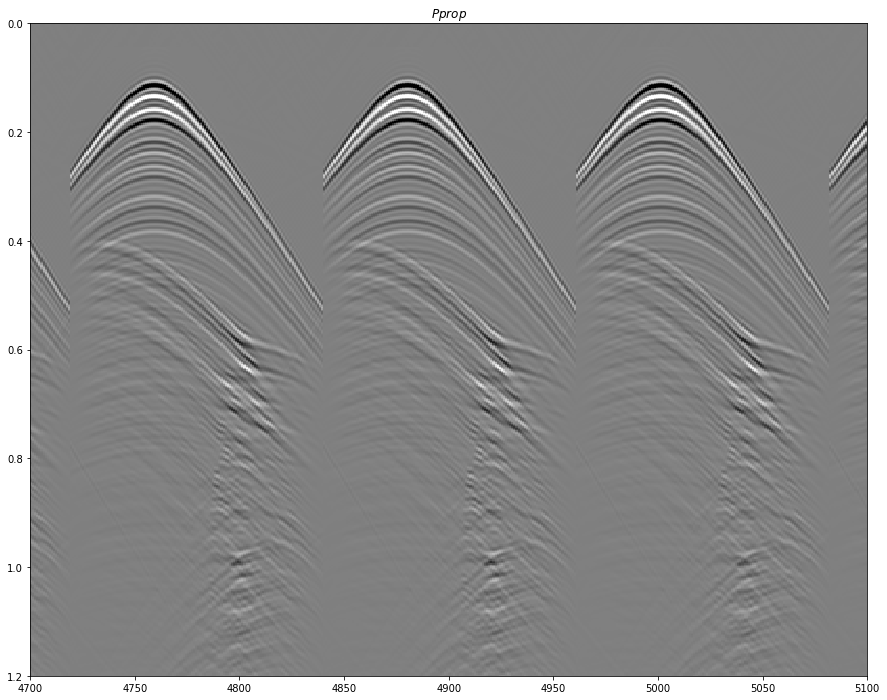

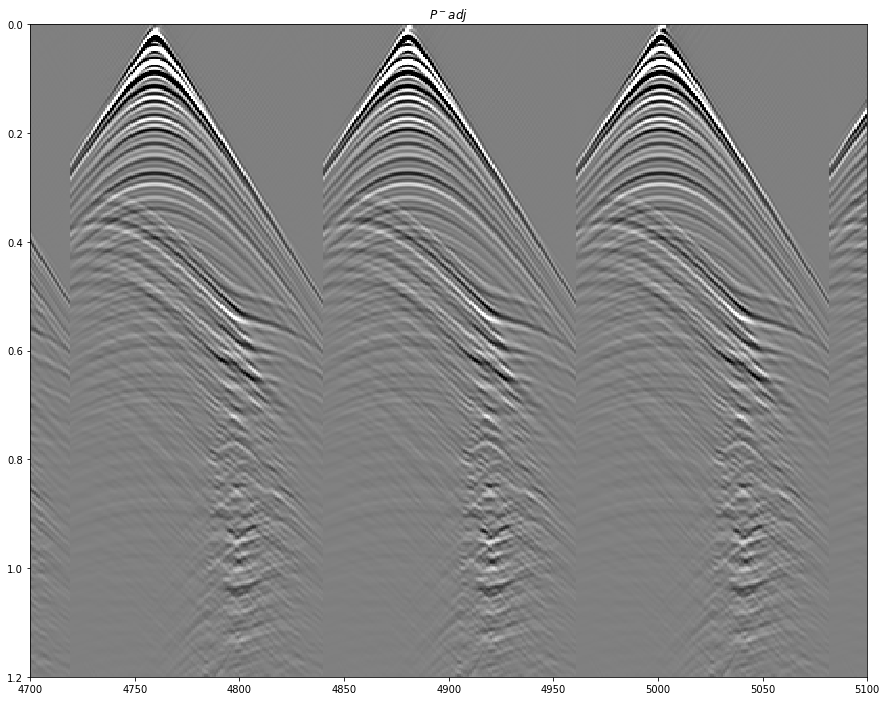

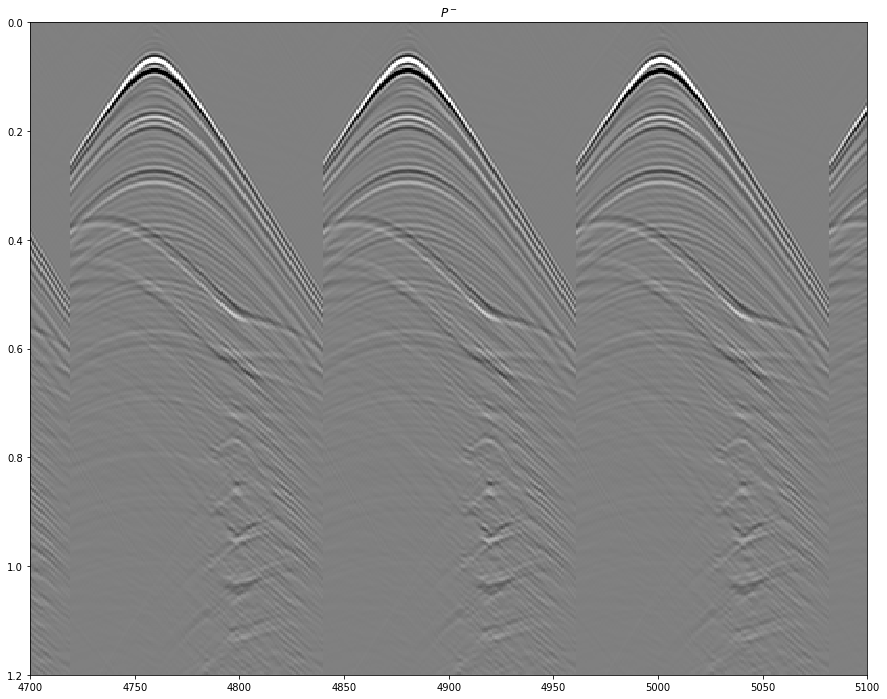

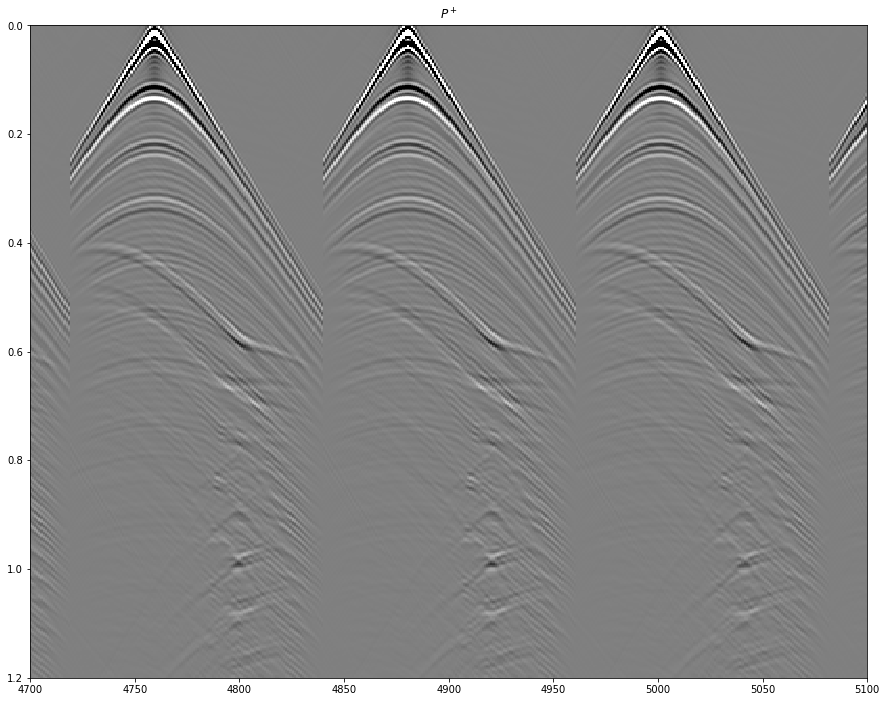

In [19]:
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 12))
axs.imshow(p.reshape(nt, nrx*nry), cmap='gray', 
           vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
           extent = (0, nr, t[-1], t[0]))
axs.set_title(r'$P$')
axs.axis('tight');
axs.set_xlim(nr//2 - 200, nr//2 + 200)
axs.set_ylim(1.2, 0);
fig.savefig('/Users/matteoravasi/Desktop/P.png')

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 12))
axs.imshow(p_prop.reshape(nt, nrx*nry), cmap='gray', 
           vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
           extent = (0, nr, t[-1], t[0]))
axs.set_title(r'$Pprop$')
axs.axis('tight');
axs.set_xlim(nr//2 - 200, nr//2 + 200)
axs.set_ylim(1.2, 0);
fig.savefig('/Users/matteoravasi/Desktop/Pprop.png')

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 12))
axs.imshow(pup_adj.reshape(nt, nrx*nry), cmap='gray', 
           vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
           extent = (0, nr, t[-1], t[0]))
axs.set_title(r'$P^- adj$')
axs.axis('tight');
axs.set_xlim(nr//2 - 200, nr//2 + 200)
axs.set_ylim(1.2, 0);
fig.savefig('/Users/matteoravasi/Desktop/Pupadj.png')


fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 12))
axs.imshow(pup_inv.reshape(nt, nrx*nry), cmap='gray', 
              vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (0, nr, t[-1], t[0]))
axs.set_title(r'$P^-$')
axs.axis('tight')
axs.set_ylim(1.2, 0);
axs.set_xlim(nr//2 - 200, nr//2 + 200)
fig.savefig('/Users/matteoravasi/Desktop/Pup.png')

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 12))
axs.imshow(pdown_inv.reshape(nt, nrx*nry), cmap='gray', 
              vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (0, nr, t[-1], t[0]))
axs.set_title(r'$P^+$')
axs.axis('tight');
axs.set_ylim(1.2, 0);
axs.set_xlim(nr//2 - 200, nr//2 + 200)
fig.savefig('/Users/matteoravasi/Desktop/Pdown.png')